In [5]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import pandas as pd
from matplotlib.patches import Patch
from PIL import Image
import os


**Data Plotting**

Number of elements in feature list: 1002


/opt/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of reduced features list: (1002, 2)
Unique labels found: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(-1)}
Cluster 0 contains 284 elements
Cluster 1 contains 277 elements
Cluster 2 contains 416 elements
Cluster 3 contains 6 elements
Cluster 4 contains 2 elements
Cluster 5 contains 9 elements
Cluster 6 contains 2 elements
Cluster 7 contains 2 elements
[0, 0, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 1, 2, 2, 0, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 3, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 4, 1, 5, 1, 2, 2, 0, -1, 1, 1, 2, 2, 1, 0, 1, 0, 3, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 

/tmp/ipykernel_11030/1396143428.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20b", len(unique_labels))


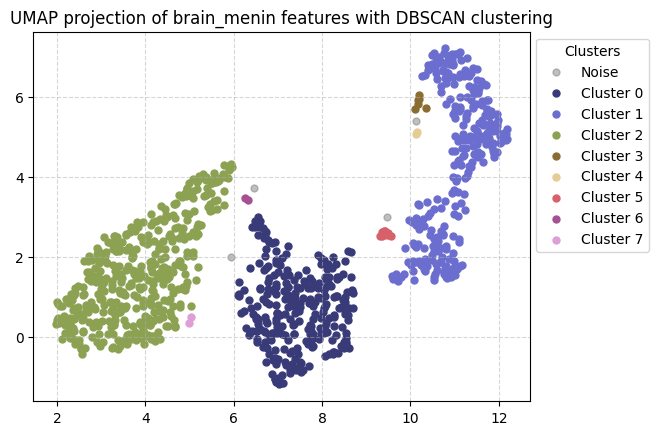

In [6]:
feature_space = torch.load("/workspaces/dbm25/data/extracted_features.pt")

label = "brain_menin"

feature_list = [elem["layer3"].numpy() for elem in feature_space if elem["class"] == label]
print("Number of elements in feature list:", len(feature_list))

# Configurazione di UMAP
reducer = UMAP(
    n_components=2,     
    n_neighbors=50,      
    min_dist=0.2,        
    metric='euclidean',  
    random_state=42      
)

embedded_data = reducer.fit_transform(feature_list)


reduced_features_list = np.array(embedded_data)
print("Shape of reduced features list:", reduced_features_list.shape)
#max_euclidean_dist = max([np.linalg.norm(a - b) for a in reduced_features_list for b in reduced_features_list]) 
#print("Max Euclidean distance:", max_euclidean_dist) # 11.838603
#distance = DistanceMetric.get_metric('euclidean')
#print(distance.pairwise(reduced_features_list[0].reshape(1,-1), reduced_features_list[1].reshape(1,-1))) 


clustering = DBSCAN(eps=0.29, min_samples=2).fit(embedded_data)
labels = clustering.labels_
print("Unique labels found:", set(labels))

n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
for cluster in set(labels):
    if cluster != -1:
        print("Cluster", cluster, "contains", np.sum(labels == cluster), "elements")
print(labels.tolist())
print(n_cluster)

df = pd.DataFrame(embedded_data, columns=["x", "y"])

df["label"] = [label for label in labels]

to_plot_df = df.loc[df.label != -1, :]
outliers_df = df.loc[df.label == -1, :]


plt.scatter(outliers_df.x, outliers_df.y, c="grey", label=f"Noise", alpha=0.5, s=25)

unique_labels = to_plot_df["label"].unique()
colors = plt.cm.get_cmap("tab20b", len(unique_labels))

for idx, cluster_label in enumerate(unique_labels):
    cluster_points = to_plot_df[to_plot_df["label"] == cluster_label]
    plt.scatter(cluster_points.x, cluster_points.y, color=colors(idx), label=f"Cluster {cluster_label}", s=25)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.title(f"UMAP projection of {label} features with DBSCAN clustering")

#show the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Clusters")

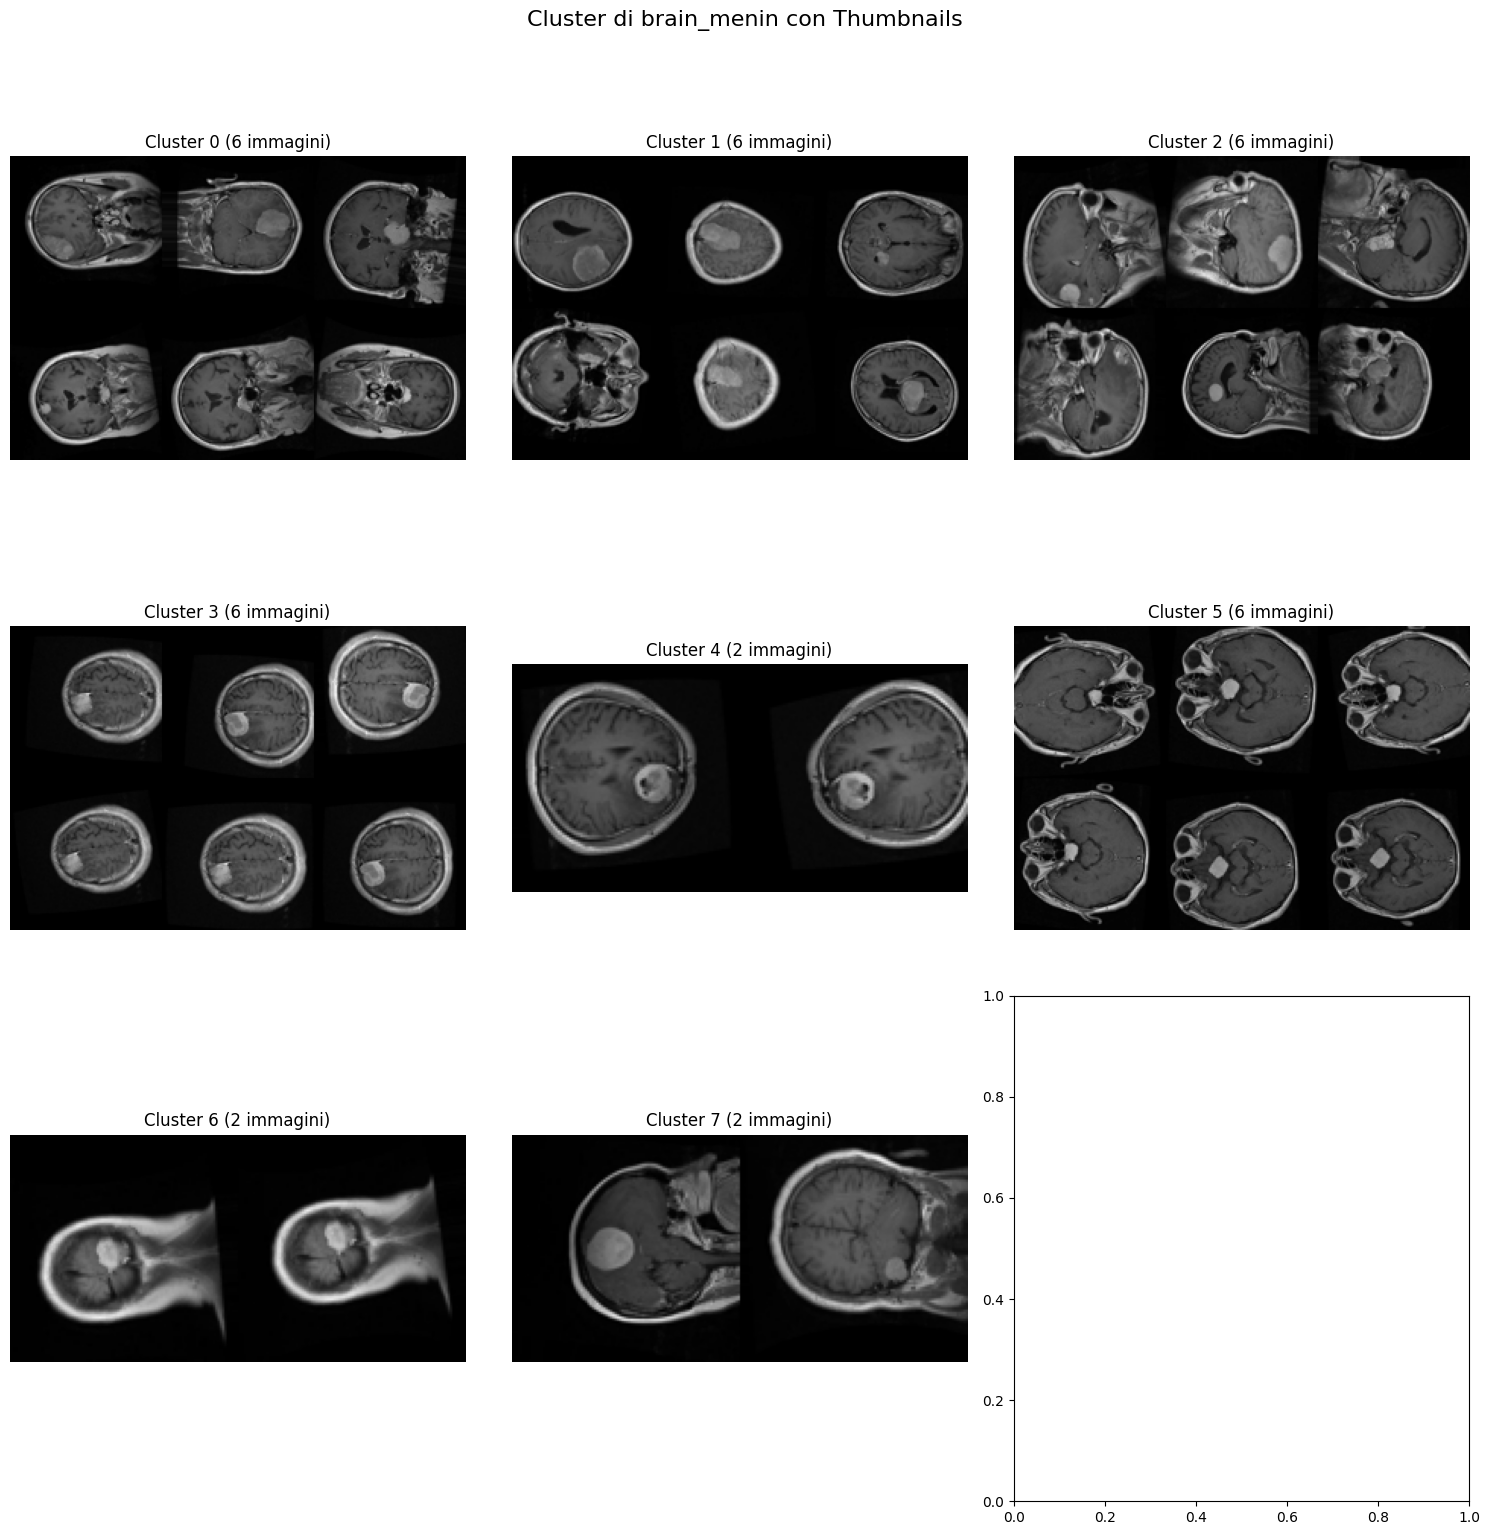

In [7]:
# Funzione per visualizzare cluster con thumbnails
def plot_clusters_with_thumbnails(feature_space, labels, label_class, max_images_per_cluster=6):
    # Filtra i dati per la classe specifica e ottieni i percorsi delle immagini
    filtered_data = [elem for elem in feature_space if elem["class"] == label_class]
    image_paths = [elem["file_path"] for elem in filtered_data]
    
    # Crea un dataframe con indici, labels e percorsi
    df_images = pd.DataFrame({
        'index': range(len(labels)),
        'label': labels,
        'image_path': image_paths
    })
    
    # Rimuovi i punti rumorosi (label -1)
    df_clean = df_images[df_images['label'] != -1]
    
    # Ottieni i cluster unici
    unique_clusters = df_clean['label'].unique()
    n_clusters = len(unique_clusters)
    
    # Calcola il numero di righe e colonne per i subplot
    cols = min(3, n_clusters)  # massimo 3 colonne
    rows = (n_clusters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if n_clusters == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, cluster_id in enumerate(unique_clusters):
        row = idx // cols
        col = idx % cols
        
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
            
        cluster_images = df_clean[df_clean['label'] == cluster_id]['image_path'].tolist()
        
        cluster_images = cluster_images[:max_images_per_cluster]
        n_images = len(cluster_images)
        
        if n_images == 0:
            ax.text(0.5, 0.5, f'Cluster {cluster_id}\nNessuna immagine', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            continue
            
        thumb_cols = min(3, n_images)
        thumb_rows = (n_images + thumb_cols - 1) // thumb_cols
        
        combined_image = None
        images_loaded = []
        
        for img_path in cluster_images:
            try:
                img = Image.open(img_path)
                img.thumbnail((100, 100))  # Resize a thumbnail
                images_loaded.append(np.array(img))
            except Exception as e:
                print(f"Errore nel caricamento di {img_path}: {e}")
                continue
        
        if images_loaded:
            # Crea  griglia immagini
            thumbnail_size = 100
            grid_width = thumb_cols * thumbnail_size
            grid_height = thumb_rows * thumbnail_size
            
            # Crea un'immagine vuota per la griglia
            grid_image = np.ones((grid_height, grid_width, 3), dtype=np.uint8) * 255
            
            for i, img_array in enumerate(images_loaded):
                if i >= max_images_per_cluster:
                    break
                    
                row_pos = (i // thumb_cols) * thumbnail_size
                col_pos = (i % thumb_cols) * thumbnail_size
                
                h, w = img_array.shape[:2]
                
                end_row = min(row_pos + h, grid_height)
                end_col = min(col_pos + w, grid_width)
                
                # sostituisci l'immagine vuota con quella caricata
                if len(img_array.shape) == 3:  
                    # Immagine a colori
                    grid_image[row_pos:end_row, col_pos:end_col] = img_array[:end_row-row_pos, :end_col-col_pos]
                else:  # Immagine in scala di grigi
                    grid_image[row_pos:end_row, col_pos:end_col] = np.stack([img_array[:end_row-row_pos, :end_col-col_pos]]*3, axis=-1)
            
            ax.imshow(grid_image)
        
        ax.set_title(f'Cluster {cluster_id} ({len(cluster_images)} immagini)', fontsize=12)
        ax.axis('off')
    
    
    plt.tight_layout()
    plt.suptitle(f'Cluster di {label_class} con Thumbnails', fontsize=16, y=1.02)
    plt.show()

# Visualizza i cluster con thumbnails
plot_clusters_with_thumbnails(feature_space, labels, label)